In [1]:
import dask.distributed, os
import xarray, numpy

In [2]:
xarray.set_options(display_style='text');

Explicitly open a Dask cluster,

In [3]:
cluster = dask.distributed.LocalCluster(
    n_workers=4, processes=True,
    local_directory=os.getenv('TMPDIR'),
    ip='0.0.0.0',
)

In [4]:
client = dask.distributed.Client(cluster)
client

Client Scheduler: tcp://10.0.4.102:42327 Dashboard: http://10.0.4.102:8787/status,Cluster Workers: 4 Cores: 16 Memory: 85.90 GB


Specify file paths,

In [5]:
source_path='/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output'

In [6]:
example_file='1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc'

In [7]:
target_path='/gxfs_work1/geomar/smomw260/github/NEMO-to-cloud'

In [8]:
target_prefix='1_VIKING20X.L46-KFS003_1m_grid_T'

Clean-up target file system location,

In [9]:
!rm -r "$target_path/$target_prefix".nc "$target_path/$target_prefix".zarr

In [10]:
!ls "$target_path"

Check original netcdf format details,

In [11]:
!ncdump -s -h "$source_path/$example_file"

netcdf \1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T {
dimensions:
	y = 2499 ;
	x = 2404 ;
	deptht = 46 ;
	axis_nbounds = 2 ;
	time_counter = UNLIMITED ; // (12 currently)
variables:
	float nav_lat(y, x) ;
		nav_lat:standard_name = "latitude" ;
		nav_lat:long_name = "Latitude" ;
		nav_lat:units = "degrees_north" ;
		nav_lat:_Storage = "chunked" ;
		nav_lat:_ChunkSizes = 2499, 2404 ;
		nav_lat:_Endianness = "little" ;
	float nav_lon(y, x) ;
		nav_lon:standard_name = "longitude" ;
		nav_lon:long_name = "Longitude" ;
		nav_lon:units = "degrees_east" ;
		nav_lon:_Storage = "chunked" ;
		nav_lon:_ChunkSizes = 2499, 2404 ;
		nav_lon:_Endianness = "little" ;
	float deptht(deptht) ;
		deptht:name = "deptht" ;
		deptht:long_name = "Vertical T levels" ;
		deptht:units = "m" ;
		deptht:positive = "down" ;
		deptht:bounds = "deptht_bounds" ;
		deptht:_Storage = "contiguous" ;
		deptht:_Endianness = "little" ;
	float deptht_bounds(deptht, axis_nbounds) ;
		deptht_bounds:units = "m" ;
		deptht

Open example file,

In [12]:
original_data = xarray.open_dataset(source_path+'/'+example_file)[['votemper', 'vosaline']]

In [13]:
original_data.encoding

{'unlimited_dims': {'time_counter'},
 'source': '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc'}

In [14]:
original_data.votemper.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 1, 2499, 2404),
 'source': '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc',
 'original_shape': (12, 46, 2499, 2404),
 'dtype': dtype('float32'),
 'missing_value': 1e+20,
 '_FillValue': 1e+20,
 'coordinates': 'time_centered nav_lat nav_lon'}

In [15]:
original_data.vosaline.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 1, 2499, 2404),
 'source': '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc',
 'original_shape': (12, 46, 2499, 2404),
 'dtype': dtype('float32'),
 'missing_value': 1e+20,
 '_FillValue': 1e+20,
 'coordinates': 'time_centered nav_lat nav_lon'}

CPU times: user 1.22 s, sys: 394 ms, total: 1.61 s
Wall time: 2.79 s


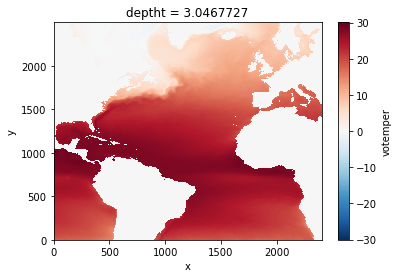

In [16]:
%time original_data.votemper.isel(deptht=0).mean('time_counter').plot()

CPU times: user 1.04 s, sys: 307 ms, total: 1.35 s
Wall time: 2.3 s


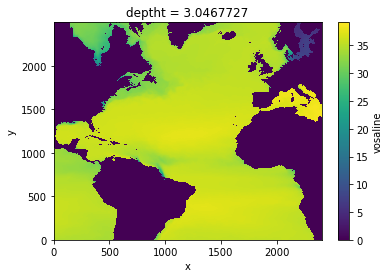

In [17]:
%time original_data.vosaline.isel(deptht=0).mean('time_counter').plot()

Specify a target chunk size,

In [18]:
# this one fits nicely to the original chunks and is very speedy...
original_data_rechunked = original_data.chunk({
    'time_counter': 1,
    'deptht': None, 'y': None, 'x': None,
})

In [19]:
# this one might already be useful...
original_data_rechunked_not_used_here = original_data.chunk({
    'time_counter': 2,
    'deptht': None, # full size
    'y': 750, 'x': 750,
})

Check that chunk size is compatible with Dask workers,

In [20]:
def print_chunk_size(da, dtype=numpy.float32):
    target_chunk_size=numpy.prod(
        [max(c) for c in list(da.chunks)]
    )*numpy.zeros(1, dtype=dtype).nbytes/1e6 # in MB
    print(f"{target_chunk_size} MB")

In [21]:
original_data_rechunked.vosaline.dtype

dtype('float32')

In [22]:
print_chunk_size(original_data_rechunked.vosaline, numpy.float32)

1105.397664 MB


In [23]:
original_data_rechunked_not_used_here.vosaline.dtype

dtype('float32')

In [24]:
print_chunk_size(original_data_rechunked_not_used_here.vosaline, numpy.float32)

207.0 MB


In [25]:
worker_mem = cluster.worker_spec[0]['options']['memory_limit']/1e9 # in GB
worker_cpus = cluster.worker_spec[0]['options']['nthreads']
this_is_several_times = 10
max_chunk_size = (worker_mem/worker_cpus)/this_is_several_times*1e3
print(f"{max_chunk_size} MB")

536.8709120000001 MB


Write to disk with an explicit variable encoding,

In [26]:
original_data_rechunked.encoding = {}

In [27]:
%%time
original_data_rechunked.to_zarr(
    store=target_path+'/'+target_prefix+'.zarr', mode='w',
    encoding={
        'votemper': {'dtype': 'float32'},
        'vosaline': {'dtype': 'float32'}
    },
)

CPU times: user 368 ms, sys: 68.5 ms, total: 437 ms
Wall time: 9.51 s


Open Zarr store,

In [28]:
zarr_store = xarray.open_zarr(
    store=target_path+'/'+target_prefix+'.zarr'
)

In [29]:
zarr_store.encoding

{'source': '/gxfs_work1/geomar/smomw260/github/NEMO-to-cloud/1_VIKING20X.L46-KFS003_1m_grid_T.zarr'}

In [30]:
zarr_store.votemper.encoding

{'chunks': (1, 46, 2499, 2404),
 'preferred_chunks': {'time_counter': 1, 'deptht': 46, 'y': 2499, 'x': 2404},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32'),
 'coordinates': 'time_centered nav_lat nav_lon'}

In [31]:
zarr_store.vosaline.encoding

{'chunks': (1, 46, 2499, 2404),
 'preferred_chunks': {'time_counter': 1, 'deptht': 46, 'y': 2499, 'x': 2404},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32'),
 'coordinates': 'time_centered nav_lat nav_lon'}

CPU times: user 656 ms, sys: 129 ms, total: 785 ms
Wall time: 1.98 s


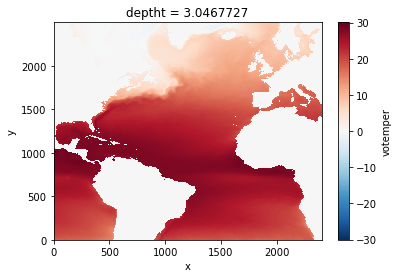

In [32]:
%time zarr_store.votemper.isel(deptht=0).mean('time_counter').plot()

CPU times: user 657 ms, sys: 109 ms, total: 766 ms
Wall time: 1.88 s


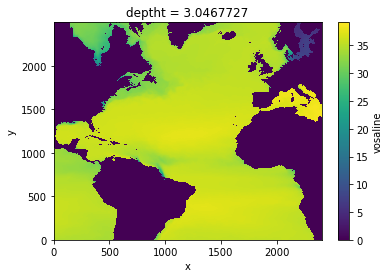

In [33]:
%time zarr_store.vosaline.isel(deptht=0).mean('time_counter').plot()

Save as netcdf again,

In [34]:
%time zarr_store.to_netcdf(target_path+'/'+target_prefix+'.nc')

CPU times: user 444 ms, sys: 62 ms, total: 506 ms
Wall time: 12.2 s


In [35]:
!ncdump -s -h "$target_path/$target_prefix".nc

netcdf \1_VIKING20X.L46-KFS003_1m_grid_T {
dimensions:
	deptht = 46 ;
	y = 2499 ;
	x = 2404 ;
	time_counter = 12 ;
variables:
	float deptht(deptht) ;
		deptht:_FillValue = NaNf ;
		deptht:bounds = "deptht_bounds" ;
		deptht:long_name = "Vertical T levels" ;
		deptht:name = "deptht" ;
		deptht:positive = "down" ;
		deptht:units = "m" ;
		deptht:_Storage = "contiguous" ;
		deptht:_Endianness = "little" ;
	float nav_lat(y, x) ;
		nav_lat:_FillValue = NaNf ;
		nav_lat:long_name = "Latitude" ;
		nav_lat:standard_name = "latitude" ;
		nav_lat:units = "degrees_north" ;
		nav_lat:_Storage = "contiguous" ;
		nav_lat:_Endianness = "little" ;
	float nav_lon(y, x) ;
		nav_lon:_FillValue = NaNf ;
		nav_lon:long_name = "Longitude" ;
		nav_lon:standard_name = "longitude" ;
		nav_lon:units = "degrees_east" ;
		nav_lon:_Storage = "contiguous" ;
		nav_lon:_Endianness = "little" ;
	double time_centered(time_counter) ;
		time_centered:_FillValue = NaN ;
		time_centered:bounds = "time_centered_bounds" ;
		

From netcdf again,

In [36]:
netcdf_data = xarray.open_dataset(target_path+'/'+target_prefix+'.nc')

In [37]:
netcdf_data.encoding

{'unlimited_dims': set(),
 'source': '/gxfs_work1/geomar/smomw260/github/NEMO-to-cloud/1_VIKING20X.L46-KFS003_1m_grid_T.nc'}

In [38]:
netcdf_data.votemper.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/gxfs_work1/geomar/smomw260/github/NEMO-to-cloud/1_VIKING20X.L46-KFS003_1m_grid_T.nc',
 'original_shape': (12, 46, 2499, 2404),
 'dtype': dtype('float32'),
 '_FillValue': nan,
 'coordinates': 'time_centered nav_lat nav_lon'}

In [39]:
netcdf_data.vosaline.encoding

{'zlib': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/gxfs_work1/geomar/smomw260/github/NEMO-to-cloud/1_VIKING20X.L46-KFS003_1m_grid_T.nc',
 'original_shape': (12, 46, 2499, 2404),
 'dtype': dtype('float32'),
 '_FillValue': nan,
 'coordinates': 'time_centered nav_lat nav_lon'}

CPU times: user 836 ms, sys: 232 ms, total: 1.07 s
Wall time: 1.19 s


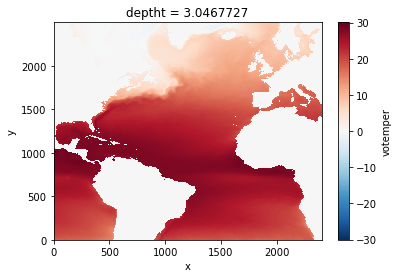

In [40]:
%time netcdf_data.votemper.isel(deptht=0).mean('time_counter').plot()

CPU times: user 842 ms, sys: 230 ms, total: 1.07 s
Wall time: 1.12 s


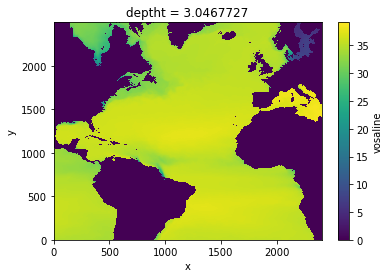

In [41]:
%time netcdf_data.vosaline.isel(deptht=0).mean('time_counter').plot()

Python environment,

In [42]:
pip list

Package                       Version
----------------------------- -------------------
alembic                       1.5.8
anyio                         2.2.0
argon2-cffi                   20.1.0
asciitree                     0.3.3
async-generator               1.10
attrs                         20.3.0
Babel                         2.9.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
bleach                        3.3.0
blinker                       1.4
bokeh                         2.3.0
brotlipy                      0.7.0
certifi                       2020.12.5
certipy                       0.1.3
cffi                          1.14.5
cftime                        1.4.1
chardet                       4.0.0
click                         7.1.2
cloudpickle                   1.6.0
conda                         4.9.2
conda-package-handling        1.7.2
cryptography                  3.4.6
cycler                        0.10.0
cytoolz                       0.11.0
dask  

In [43]:
!mamba list --explicit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.9.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platfor